In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read all sensor files (1-6)
sensor_data = {}
sensors_to_load = [1, 2, 3, 4, 5, 6]

print("Loading sensor data...")
for sensor_id in sensors_to_load:
    filename = f'data/sensor_{sensor_id}_combined_data.xlsx'
    df = pd.read_excel(filename)
    df['datetime'] = pd.to_datetime(df['datetime'])
    sensor_data[sensor_id] = df
    print(f"  Sensor {sensor_id}: {len(df)} records, date range: {df['datetime'].min()} to {df['datetime'].max()}")


Loading sensor data...
  Sensor 1: 11561 records, date range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00
  Sensor 2: 11561 records, date range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00
  Sensor 3: 10652 records, date range: 2025-08-14 14:10:00 to 2025-10-27 13:20:00
  Sensor 4: 9300 records, date range: 2025-08-14 14:10:00 to 2025-10-18 04:00:00
  Sensor 5: 11291 records, date range: 2025-08-14 14:10:00 to 2025-10-31 23:50:00
  Sensor 6: 11291 records, date range: 2025-08-14 14:10:00 to 2025-10-31 23:50:00


In [6]:
# Prepare sensor 5 as reference
sensor_5 = sensor_data[5][['datetime', 'power_W']].copy()
sensor_5 = sensor_5.rename(columns={'power_W': 'power_W_sensor_5'})

print(f"Sensor 5 reference data: {len(sensor_5)} records")
print(f"Date range: {sensor_5['datetime'].min()} to {sensor_5['datetime'].max()}")


Sensor 5 reference data: 11291 records
Date range: 2025-08-14 14:10:00 to 2025-10-31 23:50:00


In [7]:
# Calculate power differences for each sensor vs sensor 5
# Remove timestamps where either sensor has power = 0
differences = {}
sensors_to_compare = [1, 2, 3, 4, 6]  # Exclude sensor 5 itself

for sensor_id in sensors_to_compare:
    # Get sensor data
    sensor_df = sensor_data[sensor_id][['datetime', 'power_W']].copy()
    sensor_df = sensor_df.rename(columns={'power_W': f'power_W_sensor_{sensor_id}'})
    
    # Merge with sensor 5 on datetime
    merged = pd.merge(sensor_5, sensor_df, on='datetime', how='inner')
    
    # Count before filtering
    count_before = len(merged)
    
    # Remove timestamps where either sensor has power = 0
    merged = merged[
        (merged['power_W_sensor_5'] != 0) & 
        (merged[f'power_W_sensor_{sensor_id}'] != 0)
    ].copy()
    
    # Count after filtering
    count_after = len(merged)
    removed = count_before - count_after
    
    # Calculate difference (sensor_X - sensor_5)
    merged['power_diff'] = merged[f'power_W_sensor_{sensor_id}'] - merged['power_W_sensor_5']
    
    differences[sensor_id] = merged[['datetime', 'power_diff']].copy()
    print(f"  Sensor {sensor_id} vs Sensor 5: {count_before} common timestamps, "
          f"removed {removed} with zero power, {count_after} remaining")

print(f"\nTotal differences calculated: {len(differences)} comparisons")


  Sensor 1 vs Sensor 5: 11291 common timestamps, removed 9867 with zero power, 1424 remaining
  Sensor 2 vs Sensor 5: 11291 common timestamps, removed 9870 with zero power, 1421 remaining
  Sensor 3 vs Sensor 5: 10652 common timestamps, removed 9228 with zero power, 1424 remaining
  Sensor 4 vs Sensor 5: 9300 common timestamps, removed 7876 with zero power, 1424 remaining
  Sensor 6 vs Sensor 5: 11291 common timestamps, removed 9867 with zero power, 1424 remaining

Total differences calculated: 5 comparisons


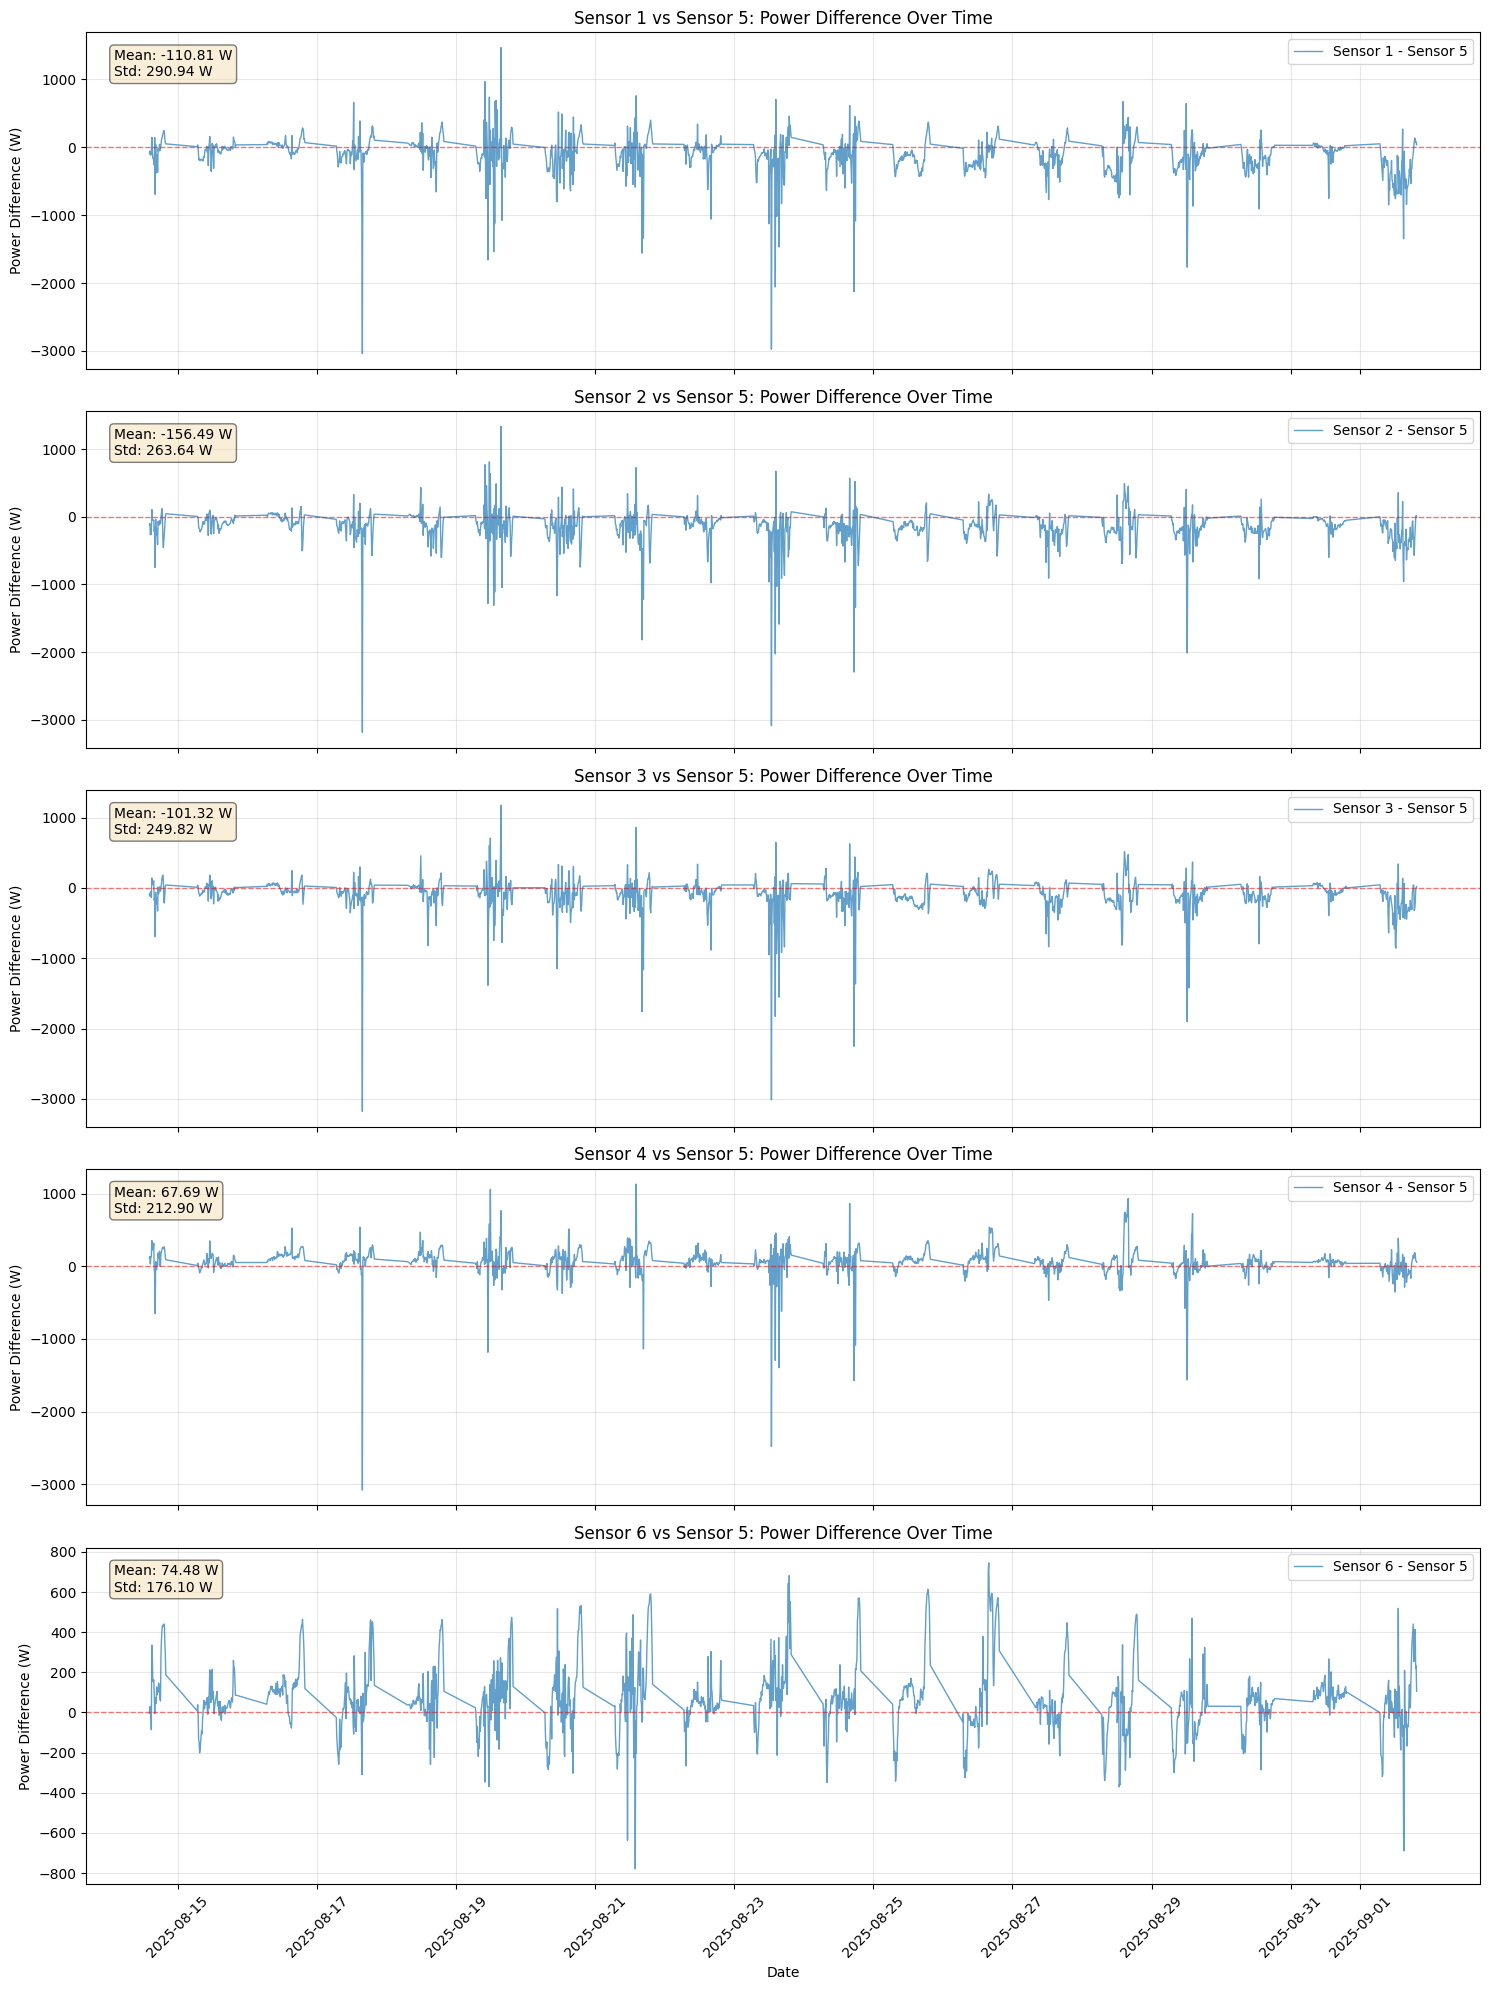

In [8]:
# Plot power differences over time
fig, axes = plt.subplots(len(sensors_to_compare), 1, figsize=(15, 4*len(sensors_to_compare)), sharex=True)

if len(sensors_to_compare) == 1:
    axes = [axes]  # Make it iterable if only one subplot

for idx, sensor_id in enumerate(sensors_to_compare):
    diff_df = differences[sensor_id].sort_values('datetime')
    
    axes[idx].plot(diff_df['datetime'], diff_df['power_diff'], 
                   alpha=0.7, linewidth=1, label=f'Sensor {sensor_id} - Sensor 5')
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].set_ylabel('Power Difference (W)', fontsize=10)
    axes[idx].set_title(f'Sensor {sensor_id} vs Sensor 5: Power Difference Over Time', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics
    mean_diff = diff_df['power_diff'].mean()
    std_diff = diff_df['power_diff'].std()
    axes[idx].text(0.02, 0.95, f'Mean: {mean_diff:.2f} W\nStd: {std_diff:.2f} W',
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].set_xlabel('Date', fontsize=10)
axes[-1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [9]:
# Summary statistics
print("=" * 70)
print("POWER DIFFERENCE SUMMARY: Sensor X vs Sensor 5")
print("=" * 70)
print(f"{'Sensor':<10} {'Count':<10} {'Mean (W)':<15} {'Std (W)':<15} {'Min (W)':<15} {'Max (W)':<15}")
print("-" * 70)

for sensor_id in sensors_to_compare:
    diff_df = differences[sensor_id]
    print(f"{sensor_id:<10} {len(diff_df):<10} {diff_df['power_diff'].mean():<15.2f} "
          f"{diff_df['power_diff'].std():<15.2f} {diff_df['power_diff'].min():<15.2f} "
          f"{diff_df['power_diff'].max():<15.2f}")


POWER DIFFERENCE SUMMARY: Sensor X vs Sensor 5
Sensor     Count      Mean (W)        Std (W)         Min (W)         Max (W)        
----------------------------------------------------------------------
1          1424       -110.81         290.94          -3040.52        1469.41        
2          1421       -156.49         263.64          -3189.67        1336.96        
3          1424       -101.32         249.82          -3175.33        1176.48        
4          1424       67.69           212.90          -3079.50        1131.02        
6          1424       74.48           176.10          -779.21         745.25         


# Analysis for Sensors 9, 11, 12, 14, 15 (Sensor 15 as reference)


In [10]:
# Read sensor files for sensors 9, 11, 12, 14, 15
sensor_data_2 = {}
sensors_to_load_2 = [9, 11, 12, 14, 15]

print("Loading sensor data (group 2)...")
for sensor_id in sensors_to_load_2:
    filename = f'data/sensor_{sensor_id}_combined_data.xlsx'
    df = pd.read_excel(filename)
    df['datetime'] = pd.to_datetime(df['datetime'])
    sensor_data_2[sensor_id] = df
    print(f"  Sensor {sensor_id}: {len(df)} records, date range: {df['datetime'].min()} to {df['datetime'].max()}")


Loading sensor data (group 2)...
  Sensor 9: 717 records, date range: 2025-08-14 14:10:00 to 2025-08-19 13:30:00
  Sensor 11: 11561 records, date range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00
  Sensor 12: 10553 records, date range: 2025-08-19 17:10:00 to 2025-10-31 23:50:00
  Sensor 14: 10098 records, date range: 2025-08-12 17:10:00 to 2025-10-21 20:00:00
  Sensor 15: 9733 records, date range: 2025-08-12 17:10:00 to 2025-10-19 07:10:00


In [11]:
# Prepare sensor 15 as reference
sensor_15 = sensor_data_2[15][['datetime', 'power_W']].copy()
sensor_15 = sensor_15.rename(columns={'power_W': 'power_W_sensor_15'})

print(f"Sensor 15 reference data: {len(sensor_15)} records")
print(f"Date range: {sensor_15['datetime'].min()} to {sensor_15['datetime'].max()}")


Sensor 15 reference data: 9733 records
Date range: 2025-08-12 17:10:00 to 2025-10-19 07:10:00


In [12]:
# Calculate power differences for each sensor vs sensor 15
# Remove timestamps where either sensor has power = 0
differences_2 = {}
sensors_to_compare_2 = [9, 11, 12, 14]  # Exclude sensor 15 itself

for sensor_id in sensors_to_compare_2:
    # Get sensor data
    sensor_df = sensor_data_2[sensor_id][['datetime', 'power_W']].copy()
    sensor_df = sensor_df.rename(columns={'power_W': f'power_W_sensor_{sensor_id}'})
    
    # Merge with sensor 15 on datetime
    merged = pd.merge(sensor_15, sensor_df, on='datetime', how='inner')
    
    # Count before filtering
    count_before = len(merged)
    
    # Remove timestamps where either sensor has power = 0
    merged = merged[
        (merged['power_W_sensor_15'] != 0) & 
        (merged[f'power_W_sensor_{sensor_id}'] != 0)
    ].copy()
    
    # Count after filtering
    count_after = len(merged)
    removed = count_before - count_after
    
    # Calculate difference (sensor_X - sensor_15)
    merged['power_diff'] = merged[f'power_W_sensor_{sensor_id}'] - merged['power_W_sensor_15']
    
    differences_2[sensor_id] = merged[['datetime', 'power_diff']].copy()
    print(f"  Sensor {sensor_id} vs Sensor 15: {count_before} common timestamps, "
          f"removed {removed} with zero power, {count_after} remaining")

print(f"\nTotal differences calculated: {len(differences_2)} comparisons")


  Sensor 9 vs Sensor 15: 717 common timestamps, removed 328 with zero power, 389 remaining
  Sensor 11 vs Sensor 15: 9733 common timestamps, removed 4959 with zero power, 4774 remaining
  Sensor 12 vs Sensor 15: 8725 common timestamps, removed 4486 with zero power, 4239 remaining
  Sensor 14 vs Sensor 15: 9733 common timestamps, removed 8159 with zero power, 1574 remaining

Total differences calculated: 4 comparisons


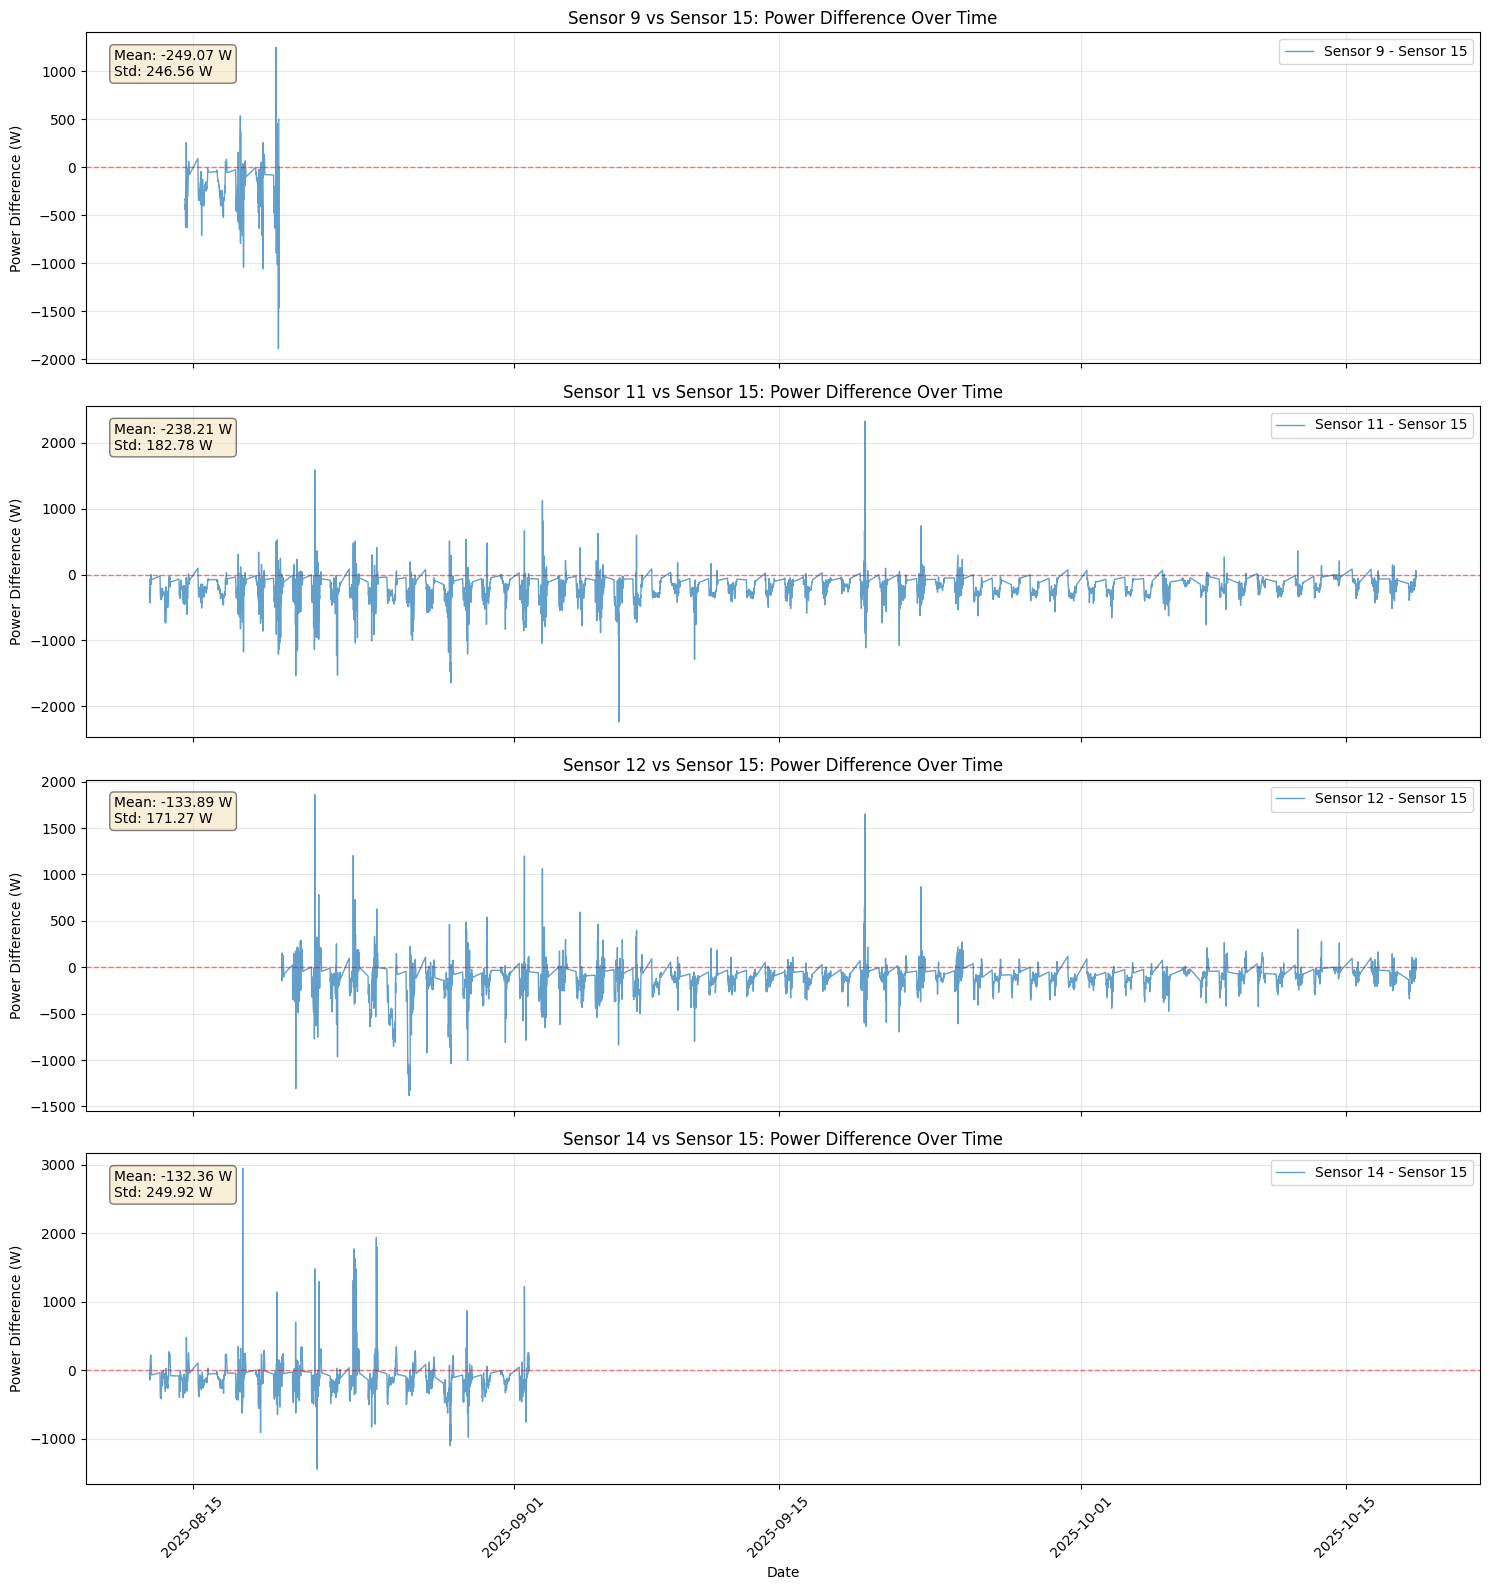

In [13]:
# Plot power differences over time for sensors vs sensor 15
fig, axes = plt.subplots(len(sensors_to_compare_2), 1, figsize=(15, 4*len(sensors_to_compare_2)), sharex=True)

if len(sensors_to_compare_2) == 1:
    axes = [axes]  # Make it iterable if only one subplot

for idx, sensor_id in enumerate(sensors_to_compare_2):
    diff_df = differences_2[sensor_id].sort_values('datetime')
    
    axes[idx].plot(diff_df['datetime'], diff_df['power_diff'], 
                   alpha=0.7, linewidth=1, label=f'Sensor {sensor_id} - Sensor 15')
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].set_ylabel('Power Difference (W)', fontsize=10)
    axes[idx].set_title(f'Sensor {sensor_id} vs Sensor 15: Power Difference Over Time', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics
    mean_diff = diff_df['power_diff'].mean()
    std_diff = diff_df['power_diff'].std()
    axes[idx].text(0.02, 0.95, f'Mean: {mean_diff:.2f} W\nStd: {std_diff:.2f} W',
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].set_xlabel('Date', fontsize=10)
axes[-1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Summary statistics for sensors vs sensor 15
print("=" * 70)
print("POWER DIFFERENCE SUMMARY: Sensor X vs Sensor 15")
print("=" * 70)
print(f"{'Sensor':<10} {'Count':<10} {'Mean (W)':<15} {'Std (W)':<15} {'Min (W)':<15} {'Max (W)':<15}")
print("-" * 70)

for sensor_id in sensors_to_compare_2:
    diff_df = differences_2[sensor_id]
    print(f"{sensor_id:<10} {len(diff_df):<10} {diff_df['power_diff'].mean():<15.2f} "
          f"{diff_df['power_diff'].std():<15.2f} {diff_df['power_diff'].min():<15.2f} "
          f"{diff_df['power_diff'].max():<15.2f}")


# Analysis for Sensors 17, 19, 20, 22, 23, 24 (Sensor 17 as reference)


In [ ]:
# Read sensor files for sensors 17, 19, 20, 22, 23, 24
sensor_data_3 = {}
sensors_to_load_3 = [17, 19, 20, 22, 23, 24]

print("Loading sensor data (group 3)...")
for sensor_id in sensors_to_load_3:
    filename = f'data/sensor_{sensor_id}_combined_data.xlsx'
    df = pd.read_excel(filename)
    df['datetime'] = pd.to_datetime(df['datetime'])
    sensor_data_3[sensor_id] = df
    print(f"  Sensor {sensor_id}: {len(df)} records, date range: {df['datetime'].min()} to {df['datetime'].max()}")


In [ ]:
# Prepare sensor 17 as reference
sensor_17 = sensor_data_3[17][['datetime', 'power_W']].copy()
sensor_17 = sensor_17.rename(columns={'power_W': 'power_W_sensor_17'})

print(f"Sensor 17 reference data: {len(sensor_17)} records")
print(f"Date range: {sensor_17['datetime'].min()} to {sensor_17['datetime'].max()}")


In [ ]:
# Calculate power differences for each sensor vs sensor 17
# Remove timestamps where either sensor has power = 0
differences_3 = {}
sensors_to_compare_3 = [19, 20, 22, 23, 24]  # Exclude sensor 17 itself

for sensor_id in sensors_to_compare_3:
    # Get sensor data
    sensor_df = sensor_data_3[sensor_id][['datetime', 'power_W']].copy()
    sensor_df = sensor_df.rename(columns={'power_W': f'power_W_sensor_{sensor_id}'})
    
    # Merge with sensor 17 on datetime
    merged = pd.merge(sensor_17, sensor_df, on='datetime', how='inner')
    
    # Count before filtering
    count_before = len(merged)
    
    # Remove timestamps where either sensor has power = 0
    merged = merged[
        (merged['power_W_sensor_17'] != 0) & 
        (merged[f'power_W_sensor_{sensor_id}'] != 0)
    ].copy()
    
    # Count after filtering
    count_after = len(merged)
    removed = count_before - count_after
    
    # Calculate difference (sensor_X - sensor_17)
    merged['power_diff'] = merged[f'power_W_sensor_{sensor_id}'] - merged['power_W_sensor_17']
    
    differences_3[sensor_id] = merged[['datetime', 'power_diff']].copy()
    print(f"  Sensor {sensor_id} vs Sensor 17: {count_before} common timestamps, "
          f"removed {removed} with zero power, {count_after} remaining")

print(f"\nTotal differences calculated: {len(differences_3)} comparisons")


In [ ]:
# Plot power differences over time for sensors vs sensor 17
fig, axes = plt.subplots(len(sensors_to_compare_3), 1, figsize=(15, 4*len(sensors_to_compare_3)), sharex=True)

if len(sensors_to_compare_3) == 1:
    axes = [axes]  # Make it iterable if only one subplot

for idx, sensor_id in enumerate(sensors_to_compare_3):
    diff_df = differences_3[sensor_id].sort_values('datetime')
    
    axes[idx].plot(diff_df['datetime'], diff_df['power_diff'], 
                   alpha=0.7, linewidth=1, label=f'Sensor {sensor_id} - Sensor 17')
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].set_ylabel('Power Difference (W)', fontsize=10)
    axes[idx].set_title(f'Sensor {sensor_id} vs Sensor 17: Power Difference Over Time', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics
    mean_diff = diff_df['power_diff'].mean()
    std_diff = diff_df['power_diff'].std()
    axes[idx].text(0.02, 0.95, f'Mean: {mean_diff:.2f} W\nStd: {std_diff:.2f} W',
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].set_xlabel('Date', fontsize=10)
axes[-1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Summary statistics for sensors vs sensor 17
print("=" * 70)
print("POWER DIFFERENCE SUMMARY: Sensor X vs Sensor 17")
print("=" * 70)
print(f"{'Sensor':<10} {'Count':<10} {'Mean (W)':<15} {'Std (W)':<15} {'Min (W)':<15} {'Max (W)':<15}")
print("-" * 70)

for sensor_id in sensors_to_compare_3:
    diff_df = differences_3[sensor_id]
    print(f"{sensor_id:<10} {len(diff_df):<10} {diff_df['power_diff'].mean():<15.2f} "
          f"{diff_df['power_diff'].std():<15.2f} {diff_df['power_diff'].min():<15.2f} "
          f"{diff_df['power_diff'].max():<15.2f}")
